# Stock Price Forecaseting with Long-Short Term Memory (LSTM)

## 1. Introduction
Although stock prices are prone to fluctuations, stock prices tend to follow trends based on previous days prices and trends, assuming that there is no news that may significantly affect the price of a stock. This resulted in traders buying stocks based on long-term trends of its previous prices, as well as reading candlestick patterns to try to predict the movement of the stock price.

<br>

With this observation, we decided to experiement with using long short-term memory networks (LSTM) to predict stock price base on two components - its short term price and it's long term price. Stock prices is a perfect application for LSTM models as it is a time-series data. 

<br>
Let's start off by importing the libraries that we need


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error



2023-04-19 19:33:33.389023: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2a. Preprocessing

In [2]:
start_date = '2015-01-01'
end_date = '2019-12-31'

# Import dataset
df = pd.read_csv("datasets/aapl_stock_raw.csv", index_col=0)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.drop(columns=["adjclose", "volume", "ticker"], inplace=True)

# Remove entries outside daterange
df = df[start_date:end_date]

df['change'] = df['close'] - df['open']


fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])

fig.show()
df

,open,high,low,close,change
date,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,-0.514999
2015-01-05,27.072500,27.162500,26.352501,26.562500,-0.510000
2015-01-06,26.635000,26.857500,26.157499,26.565001,-0.070000
2015-01-07,26.799999,27.049999,26.674999,26.937500,0.137501
2015-01-08,27.307501,28.037500,27.174999,27.972500,0.664999
...,...,...,...,...,...
2019-12-24,71.172501,71.222504,70.730003,71.067497,-0.105003
2019-12-26,71.205002,72.495003,71.175003,72.477501,1.272499
2019-12-27,72.779999,73.492500,72.029999,72.449997,-0.330002


In [3]:
# Drop all columns except for closing price and date (index)
close_df = df[['close']]
close_df

,close
date,
2015-01-02,27.332500
2015-01-05,26.562500
2015-01-06,26.565001
2015-01-07,26.937500
2015-01-08,27.972500
...,...
2019-12-24,71.067497
2019-12-26,72.477501
2019-12-27,72.449997


## 2b. Exploratory Data Analysis
Analyse dataset features

In [4]:
df.describe()

,open,high,low,close,change
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,38.599344,38.939050,38.268752,38.619141,0.019797
std,11.002370,11.103250,10.925538,11.029897,0.464672
min,22.500000,22.917500,22.367500,22.584999,-2.275002
25%,28.950001,29.130624,28.627500,28.876250,-0.209376
50%,37.593750,38.012501,37.293751,37.638750,0.030001
75%,46.500627,46.845624,46.167500,46.500626,0.261876
max,72.779999,73.492500,72.379997,73.412498,2.217499


## 2c. Prepare training set and normalise data
x_train is an array containing the data as well as the N future prices

In [23]:
# Prepare training set
train_df = close_df['2015-01-01':'2018-12-31']

# Normalise data
scaler = MinMaxScaler(feature_range=(0,1))      # Explore using StandardScaler instead of MinMaxScaler in the future
scaled_data = scaler.fit_transform(train_df['close'].values.reshape(-1,1))

# Number of days to base prediction on:
N_PRED_DAYS = 50

x_train, y_train = [], []

for d in range(N_PRED_DAYS, len(scaled_data)):
    # Add previous days values to x_train
    x_train.append(scaled_data[d - N_PRED_DAYS: d, 0])
    # Add current day's value to y_train
    y_train.append(scaled_data[d, 0])


x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

x_train, y_train

(array([[[0.13398719],
         [0.11225571],
         [0.11232629],
         ...,
         [0.24066886],
         [0.23460098],
         [0.2441967 ]],
 
        [[0.11225571],
         [0.11232629],
         [0.12283922],
         ...,
         [0.23460098],
         [0.2441967 ],
         [0.25894307]],
 
        [[0.11232629],
         [0.12283922],
         [0.15204968],
         ...,
         [0.2441967 ],
         [0.25894307],
         [0.26903268]],
 
        ...,
 
        [[0.89621107],
         [0.93000767],
         [0.92323429],
         ...,
         [0.42609183],
         [0.39857476],
         [0.47153035]],
 
        [[0.93000767],
         [0.92323429],
         [0.8867565 ],
         ...,
         [0.39857476],
         [0.47153035],
         [0.46433354]],
 
        [[0.92323429],
         [0.8867565 ],
         [0.9099696 ],
         ...,
         [0.47153035],
         [0.46433354],
         [0.46489801]]]),
 array([0.25894307, 0.26903268, 0.26218867, 0.25089961,

# 3. Build LSTM Model


In [24]:
def LSTM_model():
    
    model = Sequential()
    
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))
    
    return model

# Training

In [25]:
model = LSTM_model()
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50, 50)            10400     
                                                                 
 dropout_3 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 50, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [26]:
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', 
                               verbose = 2, 
                               save_best_only = True,
                               monitor='loss'
                               )

hist = model.fit(x_train, 
          y_train, 
          epochs=35, 
          batch_size = 32,
          callbacks = [checkpointer])



Epoch 1/35
30/30 [==============================] - ETA: 0s - loss: 0.0275
Epoch 1: loss improved from inf to 0.02751, saving model to weights_best.hdf5
30/30 [==============================] - 4s 38ms/step - loss: 0.0275
Epoch 2/35
29/30 [============================>.] - ETA: 0s - loss: 0.0046
Epoch 2: loss improved from 0.02751 to 0.00462, saving model to weights_best.hdf5
30/30 [==============================] - 1s 38ms/step - loss: 0.0046
Epoch 3/35
29/30 [============================>.] - ETA: 0s - loss: 0.0046
Epoch 3: loss improved from 0.00462 to 0.00460, saving model to weights_best.hdf5
30/30 [==============================] - 1s 38ms/step - loss: 0.0046
Epoch 4/35
30/30 [==============================] - ETA: 0s - loss: 0.0037
Epoch 4: loss improved from 0.00460 to 0.00373, saving model to weights_best.hdf5
30/30 [==============================] - 1s 37ms/step - loss: 0.0037
Epoch 5/35
29/30 [============================>.] - ETA: 0s - loss: 0.0040
Epoch 5: loss did not imp


## 5. Predictions

In [27]:
# Prepare test dataset (2023 to end)
test_df = close_df['2019-01-01':'2019-12-31']
actual_prices = test_df['close'].values

model_inputs = close_df[len(train_df) - N_PRED_DAYS:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [28]:
x_test = []

for i in range(len(model_inputs) - N_PRED_DAYS):
    x_test.append(model_inputs[i:i+N_PRED_DAYS, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

8/8 [==============================] - 1s 12ms/step


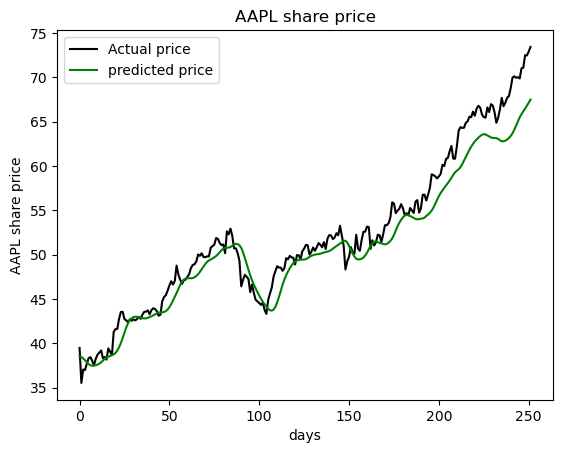

In [30]:
# Plot predicted prices
plt.plot(actual_prices, color='black', label=f"Actual price")
plt.plot(predicted_prices, color= 'green', label=f"predicted price")
plt.title("AAPL share price")
plt.xlabel("days")
plt.ylabel("AAPL share price")
plt.legend()
plt.show()

## 6. Evaluation
From our results, we can see that LSTM is able to predict the price with a deviation of 3.51% given N = 50 days worth of data

In [31]:
# Calculate the error as a percentage
diff = []
for day in range(len(actual_prices)):
    diff.append(abs(predicted_prices[day][0] - actual_prices[day]) / actual_prices[day])

print(sum(diff) / len(diff) * 100, "%")

3.322340471340237 %


In [32]:
actual_prices.shape


(252,)

In [33]:
score = model.evaluate(predicted_prices, actual_prices, verbose=0) 
print("test loss, test acc:", score)

# WORK IN PROGRESS, THIS CODE IS NOT CORRECT!!
# WANT TO ACHIEVE: % ACCURACY OF MODEL

test loss, test acc: 2710.19677734375


# 7. Experimenting with Different Values of N

We repeat what we have done, but with different values of N_PRED_DAYS, namely N = 7 (1 week) and N = 100

## 7a. N_PRED_DAYS = 7

In [35]:
# Number of days to base prediction on:
N_PRED_DAYS = 7

x_train, y_train = [], []

for d in range(N_PRED_DAYS, len(scaled_data)):
    # Add previous days values to x_train
    x_train.append(scaled_data[d - N_PRED_DAYS: d, 0])
    # Add current day's value to y_train
    y_train.append(scaled_data[d, 0])


x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

x_train, y_train

(array([[[0.13398719],
         [0.11225571],
         [0.11232629],
         ...,
         [0.15204968],
         [0.15289638],
         [0.13342272]],
 
        [[0.11225571],
         [0.11232629],
         [0.12283922],
         ...,
         [0.15289638],
         [0.13342272],
         [0.14026673]],
 
        [[0.11232629],
         [0.12283922],
         [0.15204968],
         ...,
         [0.13342272],
         [0.14026673],
         [0.13730336]],
 
        ...,
 
        [[0.51929726],
         [0.53432587],
         [0.49777745],
         ...,
         [0.42609183],
         [0.39857476],
         [0.47153035]],
 
        [[0.53432587],
         [0.49777745],
         [0.46913145],
         ...,
         [0.39857476],
         [0.47153035],
         [0.46433354]],
 
        [[0.49777745],
         [0.46913145],
         [0.42609183],
         ...,
         [0.47153035],
         [0.46433354],
         [0.46489801]]]),
 array([0.14026673, 0.13730336, 0.11627744, 0.11042123,

In [48]:
def LSTM_model():
    
    model = Sequential()
    
    model.add(LSTM(units = N_PRED_DAYS, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = N_PRED_DAYS, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = N_PRED_DAYS))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))
    
    return model

n7_model = LSTM_model()
n7_model.summary()
n7_model.compile(optimizer='adam', loss='mean_squared_error')

checkpointer = ModelCheckpoint(filepath = 'n7_weights_best.hdf5', 
                               verbose = 2, 
                               save_best_only = True,
                               monitor='loss'
                               )

hist = n7_model.fit(x_train, 
          y_train, 
          epochs=35, 
          batch_size = 32,
          callbacks = [checkpointer])


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 7, 7)              252       
                                                                 
 dropout_15 (Dropout)        (None, 7, 7)              0         
                                                                 
 lstm_16 (LSTM)              (None, 7, 7)              420       
                                                                 
 dropout_16 (Dropout)        (None, 7, 7)              0         
                                                                 
 lstm_17 (LSTM)              (None, 7)                 420       
                                                                 
 dropout_17 (Dropout)        (None, 7)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [49]:
model_inputs = close_df[len(train_df) - N_PRED_DAYS:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

x_test = []

for i in range(len(model_inputs) - N_PRED_DAYS):
    x_test.append(model_inputs[i:i+N_PRED_DAYS, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = n7_model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)



8/8 [==============================] - 1s 2ms/step


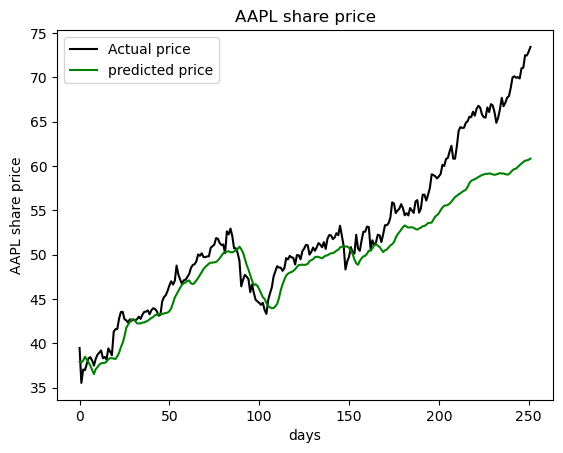

In [50]:
# Plot predicted prices
plt.plot(actual_prices, color='black', label=f"Actual price")
plt.plot(predicted_prices, color= 'green', label=f"predicted price")
plt.title("AAPL share price")
plt.xlabel("days")
plt.ylabel("AAPL share price")
plt.legend()
plt.show()

In [51]:
# Calculate the error as a percentage
diff = []
for day in range(len(actual_prices)):
    diff.append(abs(predicted_prices[day][0] - actual_prices[day]) / actual_prices[day])

print(sum(diff) / len(diff) * 100, "%")

5.14527850760092 %


## 7b. With N_PRED_DAYS = 100

In [58]:
# Number of days to base prediction on:
N_PRED_DAYS = 100

x_train, y_train = [], []

for d in range(N_PRED_DAYS, len(scaled_data)):
    # Add previous days values to x_train
    x_train.append(scaled_data[d - N_PRED_DAYS: d, 0])
    # Add current day's value to y_train
    y_train.append(scaled_data[d, 0])


x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

x_train, y_train



(array([[[0.13398719],
         [0.11225571],
         [0.11232629],
         ...,
         [0.2977492 ],
         [0.27714666],
         [0.29422136]],
 
        [[0.11225571],
         [0.11232629],
         [0.12283922],
         ...,
         [0.27714666],
         [0.29422136],
         [0.29238693]],
 
        [[0.11232629],
         [0.12283922],
         [0.15204968],
         ...,
         [0.29422136],
         [0.29238693],
         [0.28180342]],
 
        ...,
 
        [[0.83009949],
         [0.83771962],
         [0.82389046],
         ...,
         [0.42609183],
         [0.39857476],
         [0.47153035]],
 
        [[0.83771962],
         [0.82389046],
         [0.82487825],
         ...,
         [0.39857476],
         [0.47153035],
         [0.46433354]],
 
        [[0.82389046],
         [0.82487825],
         [0.83637903],
         ...,
         [0.47153035],
         [0.46433354],
         [0.46489801]]]),
 array([0.29238693, 0.28180342, 0.28363786, 0.27954567,

In [59]:
def LSTM_model():
    
    model = Sequential()
    
    model.add(LSTM(units = N_PRED_DAYS, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = N_PRED_DAYS, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = N_PRED_DAYS))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))
    
    return model

n100_model = LSTM_model()
n100_model.summary()
n100_model.compile(optimizer='adam', loss='mean_squared_error')

checkpointer = ModelCheckpoint(filepath = 'n100_weights_best.hdf5', 
                               verbose = 2, 
                               save_best_only = True,
                               monitor='loss'
                               )

hist = n100_model.fit(x_train, 
          y_train, 
          epochs=35, 
          batch_size = 32,
          callbacks = [checkpointer])


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 100, 100)          40800     
                                                                 
 dropout_21 (Dropout)        (None, 100, 100)          0         
                                                                 
 lstm_22 (LSTM)              (None, 100, 100)          80400     
                                                                 
 dropout_22 (Dropout)        (None, 100, 100)          0         
                                                                 
 lstm_23 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_23 (Dropout)        (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                

8/8 [==============================] - 1s 45ms/step


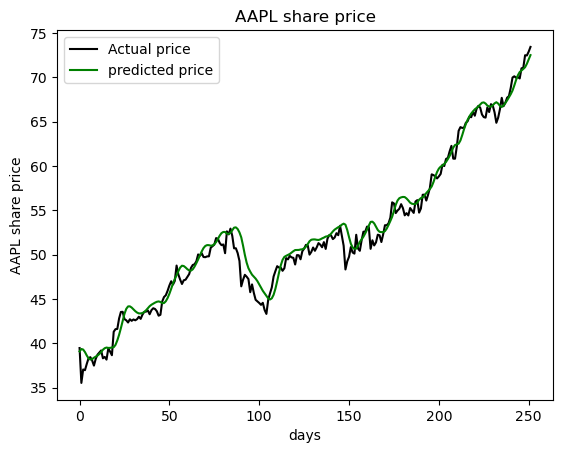

In [60]:
model_inputs = close_df[len(train_df) - N_PRED_DAYS:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

x_test = []

for i in range(len(model_inputs) - N_PRED_DAYS):
    x_test.append(model_inputs[i:i+N_PRED_DAYS, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = n100_model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Plot predicted prices
plt.plot(actual_prices, color='black', label=f"Actual price")
plt.plot(predicted_prices, color= 'green', label=f"predicted price")
plt.title("AAPL share price")
plt.xlabel("days")
plt.ylabel("AAPL share price")
plt.legend()
plt.show()

In [61]:
# Calculate the error as a percentage
diff = []
for day in range(len(actual_prices)):
    diff.append(abs(predicted_prices[day][0] - actual_prices[day]) / actual_prices[day])

print(sum(diff) / len(diff) * 100, "%")

1.926955265004792 %
